In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from itertools import product
from collections import defaultdict

%matplotlib inline

In [ ]:
BASE_DIR = os.getcwd()
csv_path = "sample_data/drug200.csv"

df = pd.read_csv(os.path.join(BASE_DIR, csv_path))
df

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC
196,16,M,LOW,HIGH,12.006,drugC
197,52,M,NORMAL,HIGH,9.894,drugX
198,23,M,NORMAL,NORMAL,14.020,drugX


In [ ]:
class Tree:
    def __init__(self, threshold=None, feature=None, prediction=None):
        if threshold is not None and feature is not None and prediction is None:
            self.feature = feature
            self.threshold = threshold
            self.is_leaf = False
        elif prediction is not None and threshold is None and feature is None:
            self.prediction = prediction
            self.is_leaf = True
        else:
            self.is_leaf = None
            print('Vertex in decision tree must be either predicat(only feature and threshold)'
                  'or leaf(only prediction)')

        self.right = None
        self.left = None

In [ ]:
class Decision_tree:
    def __init__(self, max_depth=4, min_impurity_decrease=0.05, min_samples_leaf=5, criterion='entropy'):
        self.classes = []
        self.min_impurity_decrease = min_impurity_decrease
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.tree = None
        self.prediction = None

    def _find_classes_amount(self, y):
        classes_amount = defaultdict(int)

        for i in y:
            classes_amount[i] += 1

        return classes_amount

    def _find_classes_weight(self, y):
        k, N = self.classes.shape[0], len(y)
        amount = self._find_classes_amount(y)
        weight = []

        for i in y:
            weight.append(N / (k * amount[i]))

        return np.array(weight)

    def _find_impurity(self, y, weight):
        impurity = 0
        total_weight = np.sum(weight)

        if self.criterion == 'entropy':
            for cls in self.classes:
                class_weight = weight[y == cls]
                p = np.sum(class_weight) / total_weight
                if p > 0:
                    impurity -= p * np.log2(p)
            return impurity
        elif self.criterion == 'gini':
            for cls in self.classes:
                class_weight = weight[y == cls]
                p = np.sum(class_weight) / total_weight
                impurity -= p * (1 - p)
            return impurity

    def _find_best_split(self, X, y):
        best_separator = None
        best_gain = -float('inf')
        best_main_impurity = 0

        weight_node = self._find_classes_weight(y)
        total_weight = np.sum(weight_node)
        main_impurity = self._find_impurity(y, weight_node)

        for feature_index, feature in enumerate(X.T):
            if isinstance(feature[0], (int, float)):
                feature_copy = feature.copy()

                sorted_indices = np.argsort(feature_copy)
                feature_sorted = feature_copy[sorted_indices]
                y_sorted = y[sorted_indices]

                prev_value = feature_sorted[0]

                for i in range(1, len(feature_sorted)):
                    current_value = feature_sorted[i]

                    if current_value == prev_value:
                        prev_value = current_value
                        continue

                    threshold = (prev_value + current_value) / 2.0

                    left_mask = feature_copy <= threshold
                    right_mask = feature_copy > threshold

                    left_y = y[left_mask]
                    right_y = y[right_mask]

                    weight_left = self._find_classes_weight(left_y)
                    weight_right = self._find_classes_weight(right_y)

                    left_impurity = self._find_impurity(left_y, weight_left)
                    right_impurity = self._find_impurity(right_y, weight_right)

                    left_total_weight = np.sum(weight_left)
                    right_total_weight = np.sum(weight_right)

                    gain = total_weight * main_impurity - (left_total_weight * left_impurity + right_total_weight * right_impurity)

                    if gain > best_gain:
                        best_gain = gain
                        best_main_impurity = main_impurity
                        best_separator = [
                            feature_index,
                            np.where(left_mask)[0],
                            np.where(right_mask)[0],
                            threshold
                        ]

                    prev_value = current_value

        return best_main_impurity, best_gain, best_separator

    def _is_pure(self, y):
        amount = self._find_classes_amount(y)
        n = len(y)

        for _, num in amount.items():
            if num / n >= 1:
                return True
        return False

    def _build_tree(self, X, y, depth=0):

        probability_vector = self._find_classes_amount(y)

        stop_conditions = [
            len(y) < self.min_samples_leaf,
            depth >= self.max_depth,
            self._is_pure(y)
        ]

        if any(stop_conditions):
            return Tree(prediction=probability_vector)

        main_impurity, gain, split_criteria = self._find_best_split(X, y)

        if gain < self.min_impurity_decrease * main_impurity:
            return Tree(prediction=probability_vector)

        if split_criteria is None:
            return Tree(prediction=probability_vector)

        feature_index, left_index, right_index, threshold = split_criteria

        root = Tree(feature=feature_index, threshold=threshold)
        root.left = self._build_tree(X[left_index], y[left_index], depth + 1)
        root.right = self._build_tree(X[right_index], y[right_index], depth + 1)

        return root

    def _draw_node(self, ax, node, x, y, dx=1, dy=1):
        if node.is_leaf is False:
            ax.text(x, y, f"X{node.feature} ≤ {node.threshold:.2f}",
                    bbox=dict(facecolor='white', pad=5),
                    ha='center', va='center')
        else:
            ax.text(x, y, f"{len(self.prediction) + 1}",
                    ha='center', va='center',
                    bbox=dict(boxstyle='circle',
                              facecolor='white',
                              edgecolor='black',
                              linewidth=1,
                              pad=1.0))
            self.prediction.append(node.prediction)

        if node.right:
            ax.plot([x, x + dx], [y, y - dy], 'k-')
            self._draw_node(ax, node.right, x + dx, y - dy,  dx/2, dy)

        if node.left:
            ax.plot([x, x - dx], [y, y - dy], 'k-')
            self._draw_node(ax, node.left, x - dx, y - dy, dx/2, dy)

    def visualize_tree(self):
        self.prediction = []
        if self.tree:
            fig, ax = plt.subplots(figsize=(20, 8))
            self._draw_node(ax, self.tree, x=0, y=0, dx=10, dy=1)

            legend = []
            for i in range(len(self.prediction)):
                string = ''
                for key, val in self.prediction[i].items():
                    if not string:
                        string = f'{key}: {val}'
                    else:
                        string += f', {key}: {val}'
                legend.append(f'{i + 1}: ' + string)


            legend = ax.legend(legend, title='Prediction', loc='upper left')
            for i in legend.legend_handles:
                i.set_linestyle('')
                i.set_marker('.')
            ax.axis('off')
            plt.show()
        else:
            print('Before visualize, tree should be train first')

    def train(self, X, y):
        self.classes = np.unique(y)
        self.tree = self._build_tree(X, y)
        return self

    def predict(self, X):
        prediction = []
        for i in X:
            tree = self.tree
            while not tree.is_leaf:
                if i[tree.feature] >= tree.threshold:
                    tree = tree.right
                else:
                    tree = tree.left
            res = ['', 0]
            for key, val in tree.prediction.items():
                if val > res[1]: res = [key, val]
            prediction.append(res[0])

        return prediction

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [ ]:
df = df.sample(frac=1)

data = df
m, n = data.shape

X, y = data.iloc[: , :n-1], data.iloc[:, -1]

categorical_columns = ['Sex', 'BP', 'Cholesterol']
numerical_columns = ['Age', 'Na_to_K']

X_categorical = X.loc[:, categorical_columns]
X_numerical = X.loc[:, numerical_columns].to_numpy()

enc = OneHotEncoder(handle_unknown='ignore')
X_categorical = enc.fit_transform(X_categorical).toarray()

X = np.hstack([X_numerical, X_categorical])

X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        stratify=y
    )

In [ ]:
weight = defaultdict(int)
N, k = len(y_train), len(np.unique(y_train))

for i in y_train:
    weight[i] += 1

for key, val in weight.items():
    weight[key] = N / (k * val)

In [ ]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=17,
                             class_weight=weight)
clf = clf.fit(X_train, y_train)
accuracy = np.mean(clf.predict(X_test) == y_test)
print(f'Accuracy of sklearn Decision Tree: {accuracy}')

Accuracy of sklearn Decision Tree: 0.975


In [ ]:
a = Decision_tree(max_depth=10, min_impurity_decrease=0.01, min_samples_leaf=5)
a.train(X_train, y_train.to_numpy())
accuracy = np.mean(a.predict(X_test) == y_test)
print(f'Accuracy of self-written Decision Tree: {accuracy}')

Accuracy of self-written Decision Tree: 0.975


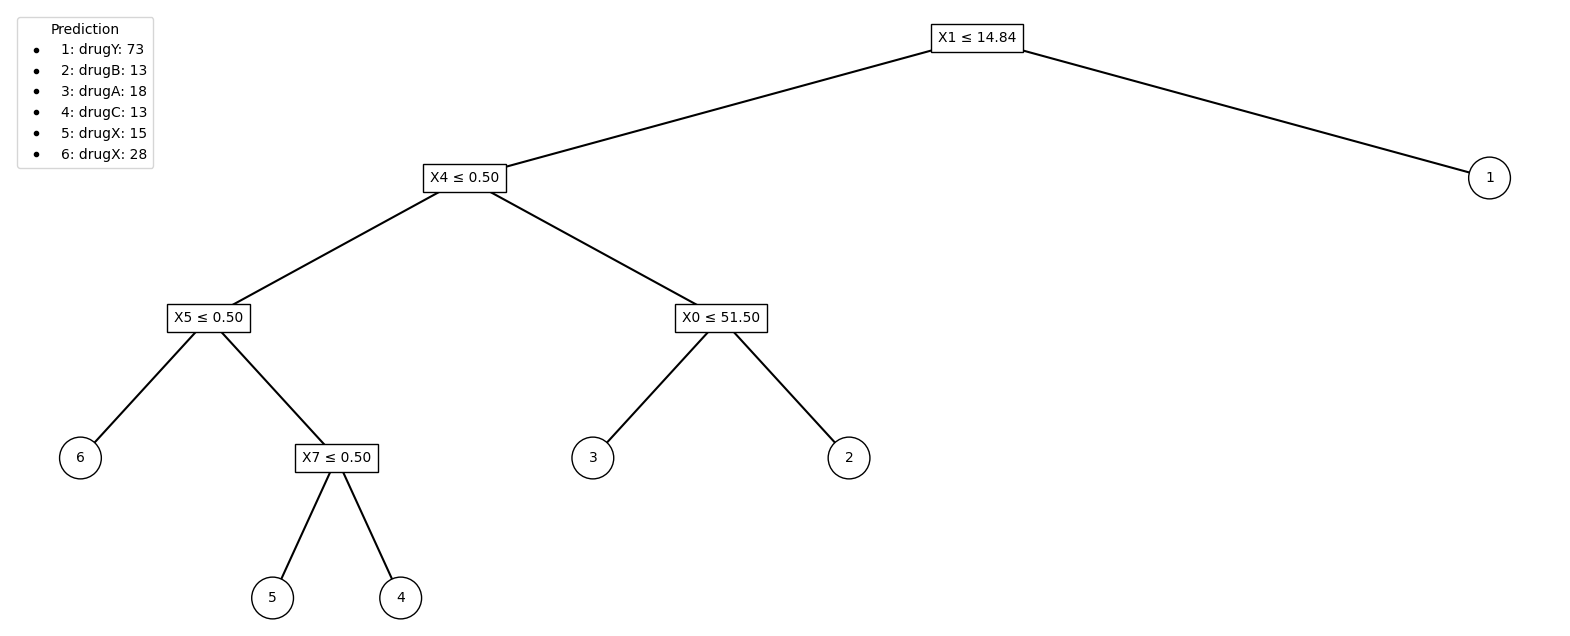

In [ ]:
a.visualize_tree()